In [100]:
from datetime import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import norm
import scipy.optimize as opt

## Load Data
1. S&P500 data
2. Sentiment data (consisting of mean Positive, Negative and Neutral sentiment per day)
3. VIX (for comparison purpose)

In [86]:
start = datetime(2010, 1, 1)
end = datetime(2024, 9, 10)

# Load S&P data
data = yf.Ticker('^GSPC').history(start=start, end=end)
data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1)).dropna()

# Load Sentiment data
sentiment_df = pd.read_csv('../data/nyt_sentiment.csv')
sentiment_df.index = pd.DatetimeIndex(sentiment_df['adjusted_date'])

# Load Vix data
vix = yf.Ticker('^VIX').history(start=start, end=end)[['Close']].rename(columns={'Close':'VIX Close'})

In [87]:
# Merge all into one dataframe
data.index = pd.DatetimeIndex(data.index.tz_localize(None))
vix.index = pd.DatetimeIndex(vix.index.tz_localize(None))
data_with_sentiment = data.join(sentiment_df, how='inner').join(vix[['VIX Close']], how='left')

log_returns = data_with_sentiment['Log_Returns']
exo_sentiment = data_with_sentiment[['mean_pos_sentiment',	'mean_neg_sentiment']].to_numpy()

data_with_sentiment.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Log_Returns,adjusted_date,mean_pos_sentiment,mean_neg_sentiment,mean_neutral_sentiment,VIX Close
2019-09-30,2967.070068,2983.850098,2967.070068,2976.739990,3249130000,0.0,0.0,0.005035,2019-09-30,0.056308,0.762604,0.181088,16.240000
2019-10-01,2983.689941,2992.530029,2938.699951,2940.250000,3560750000,0.0,0.0,-0.012334,2019-10-01,0.084752,0.525347,0.389900,18.559999
2019-10-02,2924.780029,2924.780029,2874.929932,2887.610107,3914180000,0.0,0.0,-0.018065,2019-10-02,0.064854,0.476129,0.459017,20.559999
2019-10-03,2885.379883,2911.129883,2855.939941,2910.629883,3515130000,0.0,0.0,0.007940,2019-10-03,0.267430,0.271210,0.461360,19.120001
2019-10-04,2918.560059,2953.739990,2918.560059,2952.010010,3005600000,0.0,0.0,0.014117,2019-10-04,0.132889,0.533843,0.333267,17.040001


## Define a GARCHX(p,q,z) model 

Mean Model
$$ r_t = \mu + e_t^2 $$ 
$$e_t \sim N(0, \sigma_t^2)$$

Volatility Model 
$$ \sigma_t^2 = \omega + \sum_{i=1}^p \alpha_i e_{t-i}^2 + \sum_{i=1}^q \beta_i \sigma_{i-1}^2 
+ \sum_{i=1}^{N} \sum_{j=1}^{z} \gamma_{i,t-j+1} X_{i,t-j+1} $$

where z is the number of time lags in the exogenous variables, starting from time T=t (i.e. for z=1, $\sigma_t^2$ is in terms of only $X_t$ ) and $X_{i,t}$ is variable $i$ at time $t$.

In [ ]:
class GARCH:
    """
    This class defines the GARCH model object, which contains functions
    for parameter estimation, volatility forecasting, and VaR calculation.
    """

    def __init__(self, alpha: float = 0.1, beta: float = 0.9, omega: float = 0.1,
                 gammas: float = 0.1, mu=None, p: int = 1, q: int = 1, z: int = 1):
        """
        Initialize GARCH model parameters.

        Parameters
        ----------
        alpha : float, optional
            The ARCH component parameter, by default 0.1.
        beta : float, optional
            The GARCH component parameter, by default 0.9.
        omega : float, optional
            The constant term in the variance equation, by default 0.1.
        gammas : float, optional
            The coefficient for exogenous variables, by default 0.1.
        mu : float, optional
            Mean of the returns, by default None.
        p : int, optional
            Lag order for the ARCH component, by default 1.
        q : int, optional
            Lag order for the GARCH component, by default 1.
        z : int, optional
            Lags in exogenous variable, by default 1. If 
        """
        self.alpha = np.array([alpha] * p)
        self.beta = np.array([beta] * q)
        self.omega = omega
        self.gammas = gammas  # Used when exogenous variables are present
        self.p = p
        self.q = q
        self.z = z
        self.mu = 0 if mu is None else mu
        self.sigma2 = np.array([])
        self.y = np.array([])


    def __repr__(self):
        return f"omega = {self.omega:.3g}\nalpha = {self.alpha}\nbeta = {self.beta}"


    def train(self, y: pd.Series, x=None, callback_func=None):
        """
        Estimate parameters using maximum likelihood and fit the GARCH model to the data.

        Parameters
        ----------
        y : pd.Series
            Time series data (e.g., returns).
        x : np.array, optional
            Exogenous variables for the model, by default None.
        callback_func : function, optional
            A callback function for monitoring optimization, by default None.
        """
        self.mu = np.mean(y)
        self.y = np.array(y)
        self.n_obs = len(y)
        e_t = self.y - self.mu
        try:
            self.y_index = y.index
        except Exception as e:
            self.y_index = np.arange(self.n_obs)

        init_omega = self.omega
        init_alpha = self.alpha
        init_beta = self.beta

        if x is not None:
            x = np.array(x)
            exo_var_count = x.shape[1]
            init_gammas = np.array([self.gammas] * exo_var_count * self.z)
            init_params = self.inv_repam([init_omega, *init_alpha, *init_beta, *init_gammas])
        else:
            init_params = self.inv_repam([init_omega, *init_alpha, *init_beta])

        opt_result = opt.minimize(
            self.log_likelihood,
            x0=init_params,
            args=(y, e_t, x, True),
            method='BFGS',
            callback=callback_func,
            options={'maxiter': 100}
        )
        self.opt_result = opt_result

        omega = self.repam(opt_result.x[0])
        alpha = self.repam(opt_result.x[1: self.p + 1])
        beta = self.repam(opt_result.x[self.p + 1: self.p + self.q + 1])
        if x is not None:
            gammas = self.repam(opt_result.x[self.p + self.q + 1 :]).reshape(self.z, x.shape[1])
            print(f"{omega=}\n {alpha=}\n {beta=}\n {gammas=}")
        else:
            print(f"{omega=}\n {alpha=}\n {beta=}\n")

        self.sigma2 = np.zeros(self.n_obs)
        self.sigma2[0] = np.var(y)
        
        for t in range(max(self.p, self.q, self.z), self.n_obs):
            if x is not None:
                self.sigma2[t] = (omega + np.sum(alpha * (e_t[t - self.p : t] ** 2)) 
                             + np.sum(beta * (self.sigma2[t - self.q : t])) 
                             + np.sum(gammas * x[t - self.z + 1 : t + 1, :])) 
            else:
                self.sigma2[t] = omega + np.sum(alpha * (e_t[t - self.p: t] ** 2)) + np.sum(beta * (self.sigma2[t - self.q: t]))

        #print('\nResults of BFGS minimization\n{}\n{}'.format(''.join(['-']*28), opt_result))
        #print('\nResulting params = {}'.format(self.params))


    def log_likelihood(self, params_repam, y: pd.Series, e_t, x=None, fmin=False):
        """
        Calculate the log likelihood of the GARCH model.

        Parameters
        ----------
        params_repam : np.array
            Reparameterized parameter array.
        y : pd.Series
            Time series data.
        e_t : np.array
            Residuals from the model mean.
        x : np.array, optional
            Exogenous variables, by default None.
        fmin : bool, optional
            If True, return only the likelihood value, by default False.
        """
        p, q, z = self.p, self.q, self.z
        omega, alpha, beta, gammas = self._parse_params(params_repam, x)
        
        # Calculation for log likelihood
        t_max = len(y)
        avg_log_like = 0
        sigma2 = np.zeros(t_max)
        sigma2[:max(p, q, z)] = np.var(y)

        for t in range(max(p, q, z), t_max):
            if x is not None:
                sigma2[t] = (omega + np.sum(alpha * (e_t[t - p : t] ** 2)) 
                             + np.sum(beta * (sigma2[t - q : t])) 
                             + np.sum(gammas * x[t - z + 1 : t + 1, :])) 
            else:
                sigma2[t] = omega + np.sum(alpha * (e_t[t - p: t] ** 2)) + np.sum(beta * (sigma2[t - q: t]))

            avg_log_like += (np.log(sigma2[t]) + (y[t] - self.mu) ** 2 / sigma2[t]) / t_max

        return avg_log_like if fmin else [avg_log_like, sigma2]


    def _parse_params(self, params_repam, x):
        """Helper function to parse reparameterized parameters into usable form."""
        omega = self.repam(params_repam[0])
        alpha = self.repam(params_repam[1: self.p + 1])
        beta = self.repam(params_repam[self.p + 1: self.p + self.q + 1])
        gammas = None if x is None else self.repam(params_repam[self.p + self.q + 1:]).reshape(self.z, x.shape[1])
        return omega, alpha, beta, gammas


    def plot(self, figsize=(11, 5), title=None, ts_label='Time Series', vol_label='Conditional Volatility'):
        """
        Plot the log returns and conditional volatility.

        Parameters
        ----------
        figsize : tuple, optional
            Figure size, by default (11, 5).
        """
        fig, ax1 = plt.subplots(figsize=figsize)

        ax1.plot(self.y_index, self.y, label='Log Returns', color='blue', alpha=0.5)
        ax1.set_ylabel(ts_label, color='blue')

        ax2 = ax1.twinx()
        ax2.plot(self.y_index, self.sigma2, label='Conditional Volatility', color='orange')
        ax2.set_ylabel(vol_label, color='orange')

        if not title:
            title = f'GARCH(p={self.p}, q={self.q}, z={self.z})'

        plt.title(title)
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')

        plt.grid()
        plt.show()


    def repam(self, params):
        """Reparameterize parameters for optimization stability."""
        return np.exp(params)

    def inv_repam(self, params):
        """Inverse reparameterization for optimization stability."""
        return np.log(params)


In [127]:
garch_baseline = GARCH(p=1, q=1, z=0)
garch_baseline.train(100*log_returns)

C:\Users\Wei Hao\AppData\Local\Temp\ipykernel_17788\745061004.py:149: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  avg_log_like += (np.log(sigma2[t]) + (y[t] - self.mu) ** 2 / sigma2[t]) / t_max


omega=0.03625958985060175
 alpha=array([0.1547253])
 beta=array([0.82504775])



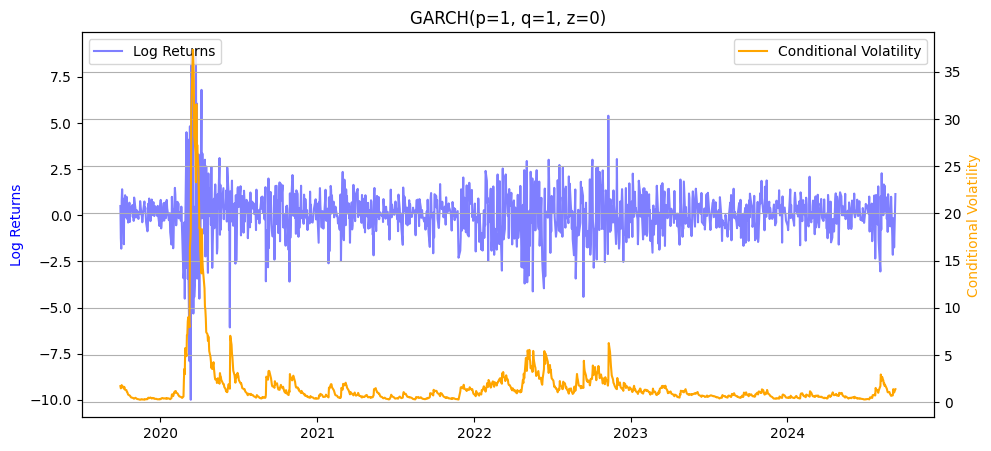

In [125]:
garch_baseline.plot()

In [98]:
garch_with_sentiment = GARCH(p=1, q=1, z=1)
garch_with_sentiment.train(100*log_returns, exo_sentiment)

C:\Users\Wei Hao\AppData\Local\Temp\ipykernel_17788\2441387895.py:149: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  avg_log_like += (np.log(sigma2[t]) + (y[t] - self.mu) ** 2 / sigma2[t]) / t_max


omega=5.85742765593311e-07
 alpha=array([0.1608213])
 beta=array([0.81158829])
 gammas=array([[3.72932149e-06, 9.79466308e-02]])


C:\Users\Wei Hao\AppData\Local\Temp\ipykernel_17788\2441387895.py:188: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(self.y_index)


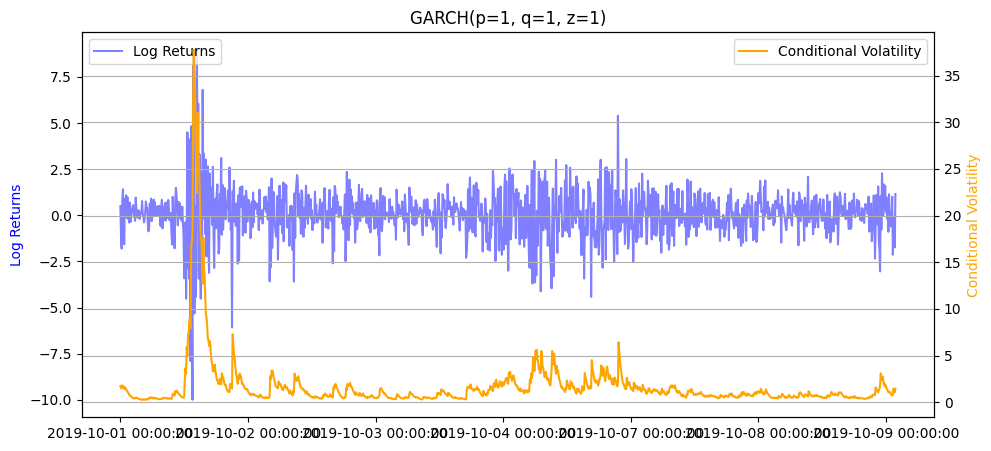

In [99]:
garch_with_sentiment.plot()

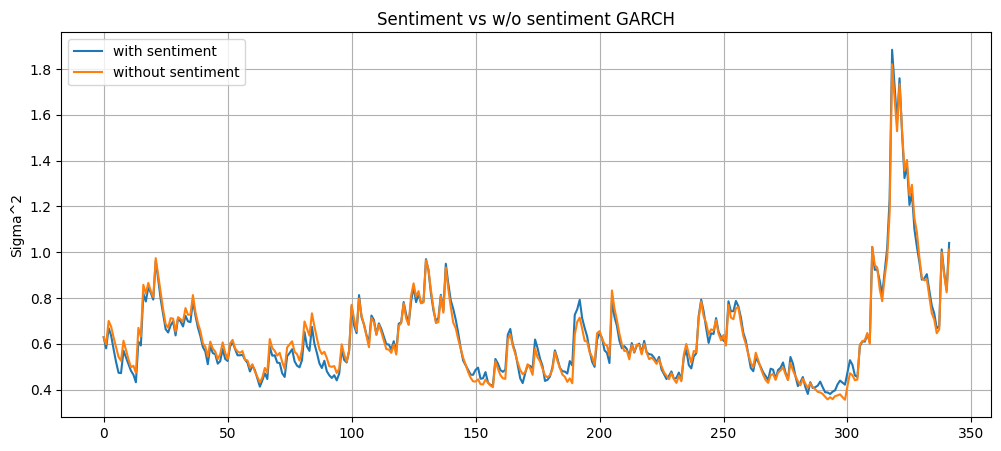

In [82]:
# Compare with and w/o sentiment

fig, ax1 = plt.subplots(figsize=(12,5))

plt.plot(garch_with_sentiment.sigma2, label='with sentiment')
plt.plot(garch_baseline.sigma2, label='without sentiment')

plt.ylabel("Sigma^2")

plt.title('Sentiment vs w/o sentiment GARCH')
plt.legend()
plt.grid()
plt.show()

In [81]:
def mse(actual, pred):
    return np.sum((actual-pred) ** 2)

mse_baseline = mse(data_with_sentiment['VIX Close'], garch_baseline.sigma2)
mse_sentiment = mse(data_with_sentiment['VIX Close'], garch_with_sentiment.sigma2)

print(f"MSE baseline: {mse_baseline:.3f}")
print(f"MSE with sentiment: {mse_sentiment:.3f}")

MSE baseline: 75570.089
MSE with sentiment: 75595.058


## Checking with arch library results for baseline GARCH model to make sure we are correct.

In [22]:
from arch import arch_model

model = arch_model(100*log_returns, vol='GARCH', mean='Constant', p=1, q=1)
garch_fit = model.fit(disp='off')

In [80]:
garch_fit

                     Constant Mean - GARCH Model Results                      
Dep. Variable:            Log_Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -398.655
Distribution:                  Normal   AIC:                           805.310
Method:            Maximum Likelihood   BIC:                           820.649
                                        No. Observations:                  342
Date:                Mon, Nov 04 2024   Df Residuals:                      341
Time:                        14:06:46   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0952  4.107e-02      2.319  2.040e-02 [1.474e-0

## Old Code
---

In [32]:
class GARCH_OLD:
    '''
    This class defines the GARCH model object which contains, functions
    for estimation and VaR forecasting.
    '''

    def __init__(self, alpha=0.1, beta=0.9, omega=0.1, gammas = 0.1, mu=None, p=1, q=1, z=1):
        """
        This class defines the GARCH model object which contains, functions
        for estimation and VaR forecasting.

        Parameters
        ----------
        alpha : float, optional
            _description_, by default 0.1
        beta : float, optional
            _description_, by default 0.9
        omega : float, optional
            _description_, by default 0.1
        gammas : float, optional
            _description_, by default 0.1
        mu : _type_, optional
            _description_, by default None
        p : int, optional
            _description_, by default 1
        q : int, optional
            _description_, by default 1
        z : int, optional
            lags in exogenous variable, by default 1 (i.e. X_t only)
        """
        # Initialize parameters
        self.gammas = gammas # Positive and negative sentiment only
        self.alpha = np.array([alpha]*p)
        self.beta = np.array([beta]*q)
        self.omega = omega
        self.p = p
        self.q = q
        self.z = z

        if (mu == None):
            self.mu = 0
        else:
            self.mu = mu

        self.sigma2 = np.array([])
        self.y = np.array([])

        
    def __repr__(self):
        return f"omega = {self.omega:.3g}\nalpha = {self.alpha:.3g}\nbeta  = {self.beta:.3g}"

    def train(self, y , x=None, callback_func=None):
        p, q, z = self.p, self.q, self.z

        self.mu = np.mean(y)
        self.y = np.array(y.values) if isinstance(y, pd.Series) else np.array(y)
        self.n_obs = len(y)
        
        e_t = y.values - self.mu

        init_omega = self.omega
        init_alpha = self.alpha
        init_beta = self.beta
        
        if x is not None:
            x = np.array(x)
            exo_var_count = x.shape[1] 
            init_gammas = np.array([self.gammas]*exo_var_count*z)
            init_params = self.inv_repam([init_omega, *init_alpha, *init_beta, *init_gammas])  # params has to be a 1d array
        else:
            init_params = self.inv_repam([init_omega, *init_alpha, *init_beta])

        opt_result = opt.minimize(self.log_likelihood,
                           x0=init_params,
                           args=(y, e_t, x, True),  
                           method='BFGS',
                           callback=callback_func,
                           options={'maxiter': 100})
        
        omega = self.repam(opt_result.x[0])
        alpha = self.repam(opt_result.x[1: self.p + 1])
        beta = self.repam(opt_result.x[self.p + 1: self.p + self.q + 1])
        if x is not None:
            gammas = self.repam(opt_result.x[self.p + self.q + 1 :]).reshape(z, x.shape[1])
            print(f"{omega=}\n {alpha=}\n {beta=}\n {gammas=}")
        else:
            print(f"{omega=}\n {alpha=}\n {beta=}\n")

        self.sigma2 = np.zeros(self.n_obs)
        self.sigma2[0] = np.var(y)
        
        for t in range(max(p, q, z), self.n_obs):
            if x is not None:
                self.sigma2[t] = (omega + np.sum(alpha * (e_t[t - p : t] ** 2)) 
                             + np.sum(beta * (self.sigma2[t - q : t])) 
                             + np.sum(gammas * x[t - z + 1 : t + 1, :])) 
            else:
                self.sigma2[t] = omega + np.sum(alpha * (e_t[t - p: t] ** 2)) + np.sum(beta * (self.sigma2[t - q: t]))

        #print('\nResults of BFGS minimization\n{}\n{}'.format(''.join(['-']*28), opt_result))
        #print('\nResulting params = {}'.format(self.params))


    def log_likelihood(self, params_repam, y: pd.Series, e_t, x=None, fmin=False):
        '''
        Takes the reparametrized 3X1 numpy array gamma = log((omega,alpha,beta))
        as input (if given or else uses the ones in self namespace).
        And returns either sum of all likelihood contributions that is a 1X1
        numpy array or both the likelihood and the (t_max,) numpy array of estimated conditional variances.
        '''
        p, q, z = self.p, self.q, self.z

        self.params = self.repam(params_repam)
        omega = self.params[0]
        alpha = self.params[1: self.p + 1]
        beta = self.params[self.p + 1: self.p + self.q + 1]

        if x is not None:
            gammas = self.params[self.p + self.q + 1 :].reshape(z, x.shape[1])

        t_max = len(y)
        avg_log_like = 0
        sigma2 = np.zeros(t_max + 1)
        sigma2[:max(p, q)] = np.var(y)

        self.mu = np.mean(y)
        e_t = y.values - self.mu

        for t in range(max(p, q), t_max):
            if x is not None:
                sigma2[t] = (omega + np.sum(alpha * (e_t[t - p : t] ** 2)) 
                             + np.sum(beta * (sigma2[t - q : t])) 
                             + np.sum(gammas * x[t - z + 1 : t + 1, :])) 
            else:
                sigma2[t] = omega + np.sum(alpha * (e_t[t - p: t] ** 2)) + np.sum(beta * (sigma2[t - q: t]))
                #print(f"{sigma2[t]=}")
            avg_log_like += (np.log (sigma2[t]) + (y[t] - self.mu)**2 / sigma2[t]) / t_max
        if fmin:
            #print(f"{avg_log_like=}")
            return avg_log_like
        else:
            return [avg_log_like, sigma2]
        

    def plot(self, figsize=(11, 5)):
        fig, ax1 = plt.subplots(figsize=figsize)

        returns_colour = 'blue'
        vol_colour = 'orange'

        ax1.plot(self.y, label='Log Returns', color=returns_colour, alpha=0.5)
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Log Returns', color=returns_colour)
        ax1.tick_params(axis='y', labelcolor=returns_colour)

        ax2 = ax1.twinx()
        ax2.plot(self.sigma2, label='Conditional Volatility', color=vol_colour)
        ax2.set_ylabel('Conditional Volatility', color=vol_colour)
        ax2.tick_params(axis='y', labelcolor=vol_colour)
        
        plt.title(f'GARCH(p={self.p}, q={self.q}, z={self.z})')
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        plt.grid()
        plt.show()


    def filter(self, y):
        omega = self.params[0]
        alpha = self.params[1]
        beta = self.params[2]

        t_max = len(y)
        sigma2 = np.zeros(t_max + 1)
        sigma2[0] = np.var(y)
        for t in range(1, t_max):
            sigma2[t] = omega + alpha * y[t - 1] ** 2 + beta * sigma2[t - 1]
        return sigma2

    def repam(self, params_repam):
        return np.exp(params_repam)

    def inv_repam(self, params):
        return np.log(params)

    def VaR(self, y, pct=(0.01, 0.025, 0.05)):
        est_variance = self.log_likelihood(y=y, fmin=False)[1]
        VaR = {}
        for alpha in pct:
            VaR[str(alpha)] = self.mu + norm.ppf(alpha) * np.sqrt(est_variance)
        return VaR

In [33]:
garch_baseline = GARCH_OLD(p=1, q=1, z=0)
garch_baseline.train(100*log_returns)

C:\Users\Wei Hao\AppData\Local\Temp\ipykernel_17788\2283911124.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  avg_log_like += (np.log (sigma2[t]) + (y[t] - self.mu)**2 / sigma2[t]) / t_max


omega=0.04226559236301376
 alpha=array([0.07969076])
 beta=array([0.85473757])



In [ ]:
garch_baseline

0.07910129965980646